In [49]:
import kagglehub
import os
from matplotlib import pyplot as plt
from PIL import Image
import xmltodict
import ipywidgets as widgets
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from scipy.signal import convolve2d

In [2]:
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

In [3]:
# Explore the dataset
#print(os.listdir(dataset_path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages"))
#print(os.listdir(dataset_path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations"))
#print(os.listdir(dataset_path + "/VOCtest_06-Nov-2007/VOCdevkit/VOC2007"))

with open(dataset_path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/000005.xml") as f:
    print(f.read())
#img = Image.open(dataset_path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000005.jpg")
#plt.imshow(img)

<annotation>
	<folder>VOC2007</folder>
	<filename>000005.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>325991873</flickrid>
	</source>
	<owner>
		<flickrid>archintent louisville</flickrid>
		<name>?</name>
	</owner>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>chair</name>
		<pose>Rear</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>263</xmin>
			<ymin>211</ymin>
			<xmax>324</xmax>
			<ymax>339</ymax>
		</bndbox>
	</object>
	<object>
		<name>chair</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>165</xmin>
			<ymin>264</ymin>
			<xmax>253</xmax>
			<ymax>372</ymax>
		</bndbox>
	</object>
	<object>
		<name>chair</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>1</difficult>
		<bndbox>
			<xmin>

In [25]:
# Load it into memory
def load_data(path):
    X = []
    y = []
    for file in os.listdir(path + "/JPEGImages"):        
        img = Image.open(path + "/JPEGImages/" + file).convert('L')
        X.append(img)

        xmlName = file[:-4] + ".xml"
        with open(path + "/Annotations/" + xmlName) as f:
            parsedFile = xmltodict.parse(f.read())

        lst = parsedFile["annotation"]["object"]
        lst = lst if type(lst) is list else [lst]

        y.append([{
                "name": x["name"],
                "box": {
                    "xmin": x["bndbox"]["xmin"],
                    "ymin": x["bndbox"]["ymin"],
                    "xmax": x["bndbox"]["xmax"],
                    "ymax": x["bndbox"]["ymax"]
                }
        } for x in lst])

    return X, y

train_images, train_labels = load_data(dataset_path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007")

In [79]:
label_output = widgets.Output()

def show_image(idx):
    plt.clf()
    plt.imshow(train_images[idx], cmap="gray")
    plt.axis('off')

    label_output.clear_output(wait=True)
    with label_output:
        print("Labels:", " ".join([x.name for x in train_labels[idx]]))

slider = widgets.IntSlider(min=0, max=len(train_images)-1)
widgets.interact(show_image, idx=slider)
display(label_output)

interactive(children=(IntSlider(value=0, description='idx', max=5010), Output()), _dom_classes=('widget-intera…

Output()

/tmp/ipykernel_49599/965996640.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_clusters)


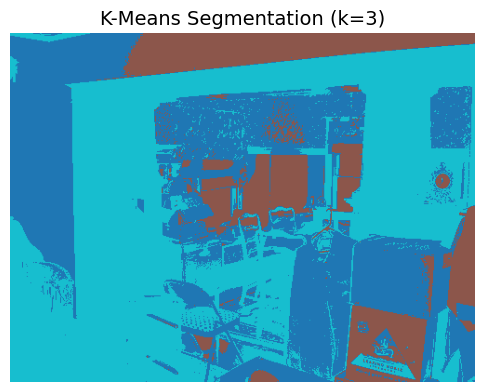

In [136]:
def clustering(img, n_clusters=4):
    # Reshape grayscale image to (height * width, 1) for clustering
    h, w = img.shape
    flat = img.reshape(-1, 1)

    # Run K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flat)
    labels = kmeans.labels_

    # --- Use a distinct color map from matplotlib ---
    # tab10 gives 10 visually distinct colors; Set3 or tab20 are also good
    cmap = cm.get_cmap('tab10', n_clusters)
    distinct_colors = (cmap.colors[:, :3] * 255).astype(np.uint8)

    # Map each cluster label to one of those colors
    clustered = distinct_colors[labels % n_clusters]
    clustered_image = clustered.reshape(h, w, 3).astype(np.uint8)

    # --- Display ---
    plt.figure(figsize=(6, 6))
    plt.imshow(clustered_image)
    plt.title(f"K-Means Segmentation (k={n_clusters})", fontsize=14)
    plt.axis("off")
    plt.show()

# Example usage
img = np.array(train_images[0])
clustering(img, n_clusters=3)

In [161]:
def render_clusters(coords, labels, feature_map, title="Clustering Result"):
    """
    Render clustered coordinates on an image.

    Parameters:
    - coords: np.array of shape (N, 2) with [row, col] coordinates
    - labels: np.array of shape (N,) with cluster labels
    - feature_map: original 2D image to get dimensions
    - title: plot title
    """
    # Count clusters (excluding noise labeled as -1)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Found {n_clusters} clusters and {n_noise} noise points")

    # Create output image
    h, w = feature_map.shape
    clustered_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Get colors (use tab20 for more clusters)
    cmap = cm.get_cmap('tab20', max(n_clusters, 1))
    distinct_colors = (cmap.colors[:, :3] * 255).astype(np.uint8)

    # Assign colors
    for i, (row, col) in enumerate(coords):
        cluster_label = labels[i]
        if cluster_label == -1:  # Noise
            clustered_image[row, col] = [50, 50, 50]  # Dark gray for noise
        else:
            clustered_image[row, col] = distinct_colors[cluster_label % len(distinct_colors)]

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(clustered_image)
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

    return clustered_image, n_clusters

def render_bounding_boxes(coords, labels, original_img, title="Bounding Boxes", min_cluster_size=5):
    """
    Render bounding boxes around clusters on the original image.

    Parameters:
    - coords: np.array of shape (N, 2) with [row, col] coordinates
    - labels: np.array of shape (N,) with cluster labels
    - original_img: original grayscale image
    - title: plot title
    - min_cluster_size: minimum points in cluster to draw box (filters noise)
    """
    # Create RGB version of original image for colored boxes
    if len(original_img.shape) == 2:
        display_img = np.stack([original_img]*3, axis=-1)
    else:
        display_img = original_img.copy()

    # Normalize to 0-255 if needed
    if display_img.max() <= 1.0:
        display_img = (display_img * 255).astype(np.uint8)
    else:
        display_img = display_img.astype(np.uint8)

    # Get unique clusters (excluding noise -1)
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    # Get colors for boxes
    cmap = cm.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=(6, 6))
    plt.imshow(display_img, cmap='gray' if len(original_img.shape) == 2 else None)

    box_count = 0
    for idx, label in enumerate(unique_labels):
        # Get all points in this cluster
        cluster_coords = coords[labels == label]

        # Skip small clusters (likely noise)
        if len(cluster_coords) < min_cluster_size:
            continue

        # Get bounding box coordinates
        min_row = cluster_coords[:, 0].min()
        max_row = cluster_coords[:, 0].max()
        min_col = cluster_coords[:, 1].min()
        max_col = cluster_coords[:, 1].max()

        # Add some padding
        padding = 2
        min_row = max(0, min_row - padding)
        max_row = min(original_img.shape[0] - 1, max_row + padding)
        min_col = max(0, min_col - padding)
        max_col = min(original_img.shape[1] - 1, max_col + padding)

        # Get color
        color = cmap(idx % len(unique_labels))[:3]

        # Draw rectangle (col, row because matplotlib uses x, y)
        width = max_col - min_col
        height = max_row - min_row
        rect = plt.Rectangle(
            (min_col, min_row), width, height,
            fill=False, edgecolor=color, linewidth=2
        )
        plt.gca().add_patch(rect)

        # Add label number
        plt.text(
            min_col, min_row - 5,
            f'{label}',
            color=color, fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )

        box_count += 1

    plt.title(f"{title} ({box_count} boxes)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()

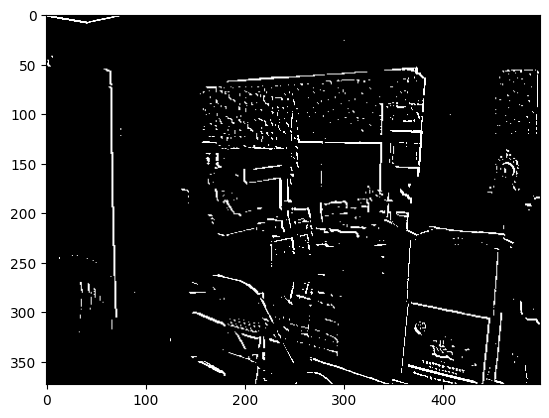

In [148]:
# Try to separate the objects in the picture by applying a convolution first
def generate_feature_map(image, threshold=1.16, bias_x=0, bias_y=0, plot=False):
    # Sobel kernels
    sobel_x = np.array([[1,  2,  1],
                        [0,  0,  0],
                        [-1, -2, -1]], dtype=np.float32)

    sobel_y = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    # Convolve (broadcast kernel across RGB channels)
    convolved_x = convolve2d(image, sobel_x, mode="valid")
    convolved_y = convolve2d(image, sobel_y, mode='valid')

    # Normalize them
    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    convolved_x = normalize(convolved_x)
    convolved_y = normalize(convolved_y)

    # Take their abs values, sum them, and then take the pixels that are > something
    convolved_x = np.abs(convolved_x) + bias_x
    convolved_y = np.abs(convolved_y) + bias_y
    feature_map = convolved_x + convolved_y
    feature_map = (feature_map > threshold).astype(int)

    if plot:
        plt.imshow(feature_map, cmap='gray')

    # Now take those pixels and turn them into an (x, y) vector
    return np.argwhere(feature_map == 1)

coords = generate_feature_map(img, plot=True)

/tmp/ipykernel_49599/3581858219.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


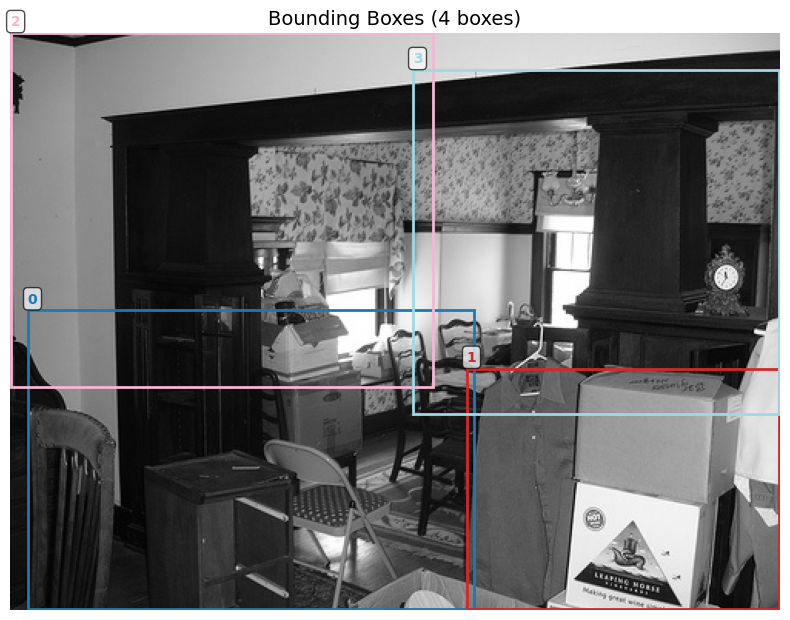

Drew 4 bounding boxes (filtered clusters with < 5 points)


In [149]:
# And finally, throw them into K-MEANS and visualize them with the different colors
n_clusters = 4

# Run K-Means on the coordinates
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
labels = kmeans.labels_
render_bounding_boxes(coords, labels, img)

/tmp/ipykernel_49599/3581858219.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


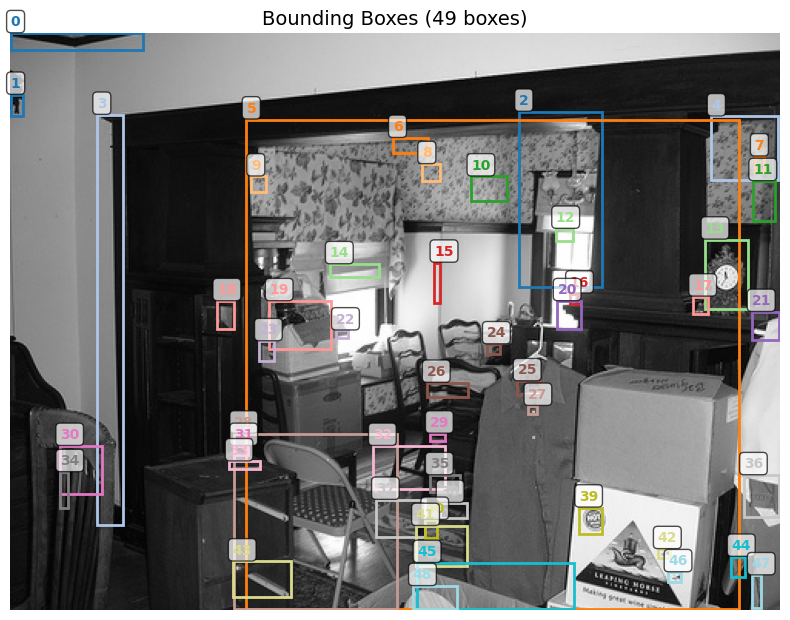

Drew 49 bounding boxes (filtered clusters with < 5 points)


In [143]:
# Now try using DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=7, min_samples=5).fit(coords)
labels = dbscan.fit_predict(coords)
render_bounding_boxes(coords, labels, img)

/tmp/ipykernel_49599/3581858219.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


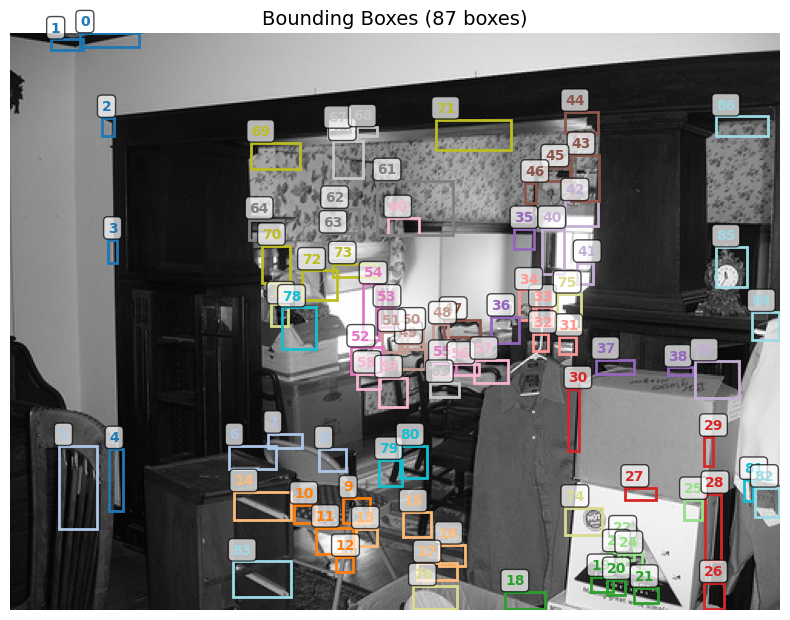

Drew 87 bounding boxes (filtered clusters with < 5 points)


In [141]:
# Try out OPTICS. Slower than DBSCAN but no need to tweak eps
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=20)
labels = optics.fit_predict(coords)
render_bounding_boxes(coords, labels, img)

/tmp/ipykernel_49599/4270896622.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


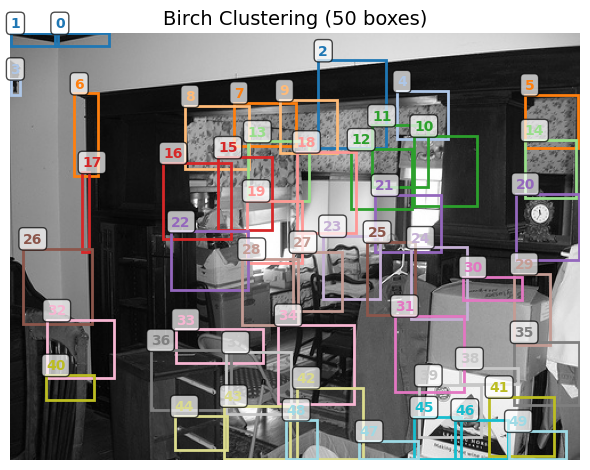

In [215]:
# Now Birch.
from sklearn.cluster import Birch
idx = 0
coords = generate_feature_map(train_images[idx], threshold=1.16)
birch = Birch(n_clusters=None, threshold=20, branching_factor=50)
labels = birch.fit_predict(coords)
render_bounding_boxes(coords, labels, np.array(train_images[idx]), title="Birch Clustering")

In [209]:
# ===============================================
# CONCURRENT GRID SEARCH (CUDA only for CNN part)
# ===============================================

import numpy as np
from PIL import Image
from sklearn.cluster import Birch
from dataclasses import dataclass
from typing import Callable, Iterable, List, Tuple, Dict, Any, Optional
from functools import partial
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import torch
import torchvision.models as models
import torchvision.transforms as T


# ================= Common =================
CUDA_AVAILABLE = torch.cuda.is_available()
CUDA_DEVICE = "cuda:0" if CUDA_AVAILABLE else "cpu"

# Limit simultaneous GPU forwards to avoid GPU thrash when we parallelize.
# Keep CPU work highly concurrent, but serialize/small-batch the GPU part.
_GPU_INFER_LOCK = threading.Semaphore(1 if CUDA_AVAILABLE else 16)


# ========= Torch Predictor (CUDA-capable, batched) =========
class TorchPredictor:
    """
    Wrap a torchvision model into:
      - __call__(img: PIL.Image) -> float  (confidence [0,1])
      - predict_batch(imgs: List[PIL.Image]) -> List[float]
    Uses CUDA if available; all non-CNN work remains on CPU.
    """
    def __init__(self, model: torch.nn.Module, device: str = "cpu", input_size: int = 224):
        self.device = device
        self.model = model.eval().to(device)
        self.preprocess = T.Compose([
            T.Resize(256),
            T.CenterCrop(input_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    @torch.inference_mode()
    def predict_batch(self, imgs: List[Image.Image]) -> List[float]:
        if not imgs:
            return []
        # Preprocess on CPU, stack to a batch, then move to device for CNN only.
        tensors = [self.preprocess(im) for im in imgs]
        x = torch.stack(tensors, dim=0)

        with _GPU_INFER_LOCK:  # ensure controlled concurrency on the GPU
            x = x.to(self.device, non_blocking=True)
            use_amp = self.device.startswith("cuda")
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = self.model(x)
                probs = torch.softmax(logits, dim=1)
                confs = probs.max(dim=1).values

        return confs.detach().float().cpu().tolist()

    def __call__(self, img: Image.Image) -> float:
        return self.predict_batch([img])[0] if img is not None else 0.0


def make_torch_predictor(model_ctor, weights="DEFAULT", device: str = "cpu", input_size: int = 224) -> TorchPredictor:
    model = model_ctor(weights=weights)
    return TorchPredictor(model=model, device=device, input_size=input_size)


# ========= Lightweight Models (CUDA only here) =========
mobilenet_pred = make_torch_predictor(models.mobilenet_v3_small,
                                      weights="DEFAULT",
                                      device=CUDA_DEVICE)
squeezenet_pred = make_torch_predictor(models.squeezenet1_1,
                                       weights="DEFAULT",
                                       device=CUDA_DEVICE)
predictors: List[TorchPredictor] = [mobilenet_pred, squeezenet_pred]


# ========= Data class for results =========
@dataclass
class GridResult:
    birch_threshold: float
    fm_threshold: float
    mean_score: float
    mean_regions: float
    mean_confidence: float


# ========= Utility functions (CPU) =========
def _to_numpy(image: Any) -> np.ndarray:
    if isinstance(image, np.ndarray):
        arr = image
        if arr.ndim == 2:
            arr = np.stack([arr] * 3, axis=-1)
        return arr
    return np.array(image.convert("RGB"))

def _bbox_from_cluster(points: np.ndarray, img_h: int, img_w: int, margin: int = 0):
    ys = points[:, 0]
    xs = points[:, 1]
    y1 = max(int(ys.min()) - margin, 0)
    x1 = max(int(xs.min()) - margin, 0)
    y2 = min(int(ys.max()) + margin, img_h - 1)
    x2 = min(int(xs.max()) + margin, img_w - 1)
    return y1, x1, y2, x2

def _crop(image_np: np.ndarray, bbox):
    y1, x1, y2, x2 = bbox
    return Image.fromarray(image_np[y1:y2+1, x1:x2+1])


def _region_confidences_batched(
    image_np: np.ndarray,
    coords: np.ndarray,
    labels: np.ndarray,
    predictors: List[TorchPredictor],
    margin: int = 2,
) -> List[float]:
    """
    Build all region crops (CPU), then run batched inference per model on GPU.
    Averaging the per-model confidences per region.
    """
    h, w = image_np.shape[:2]
    region_crops: List[Image.Image] = []
    region_indices: List[int] = []  # map each crop -> region id (0..R-1)
    unique_labs = [lab for lab in np.unique(labels) if np.any(labels == lab)]

    # Build crops for each region
    for ridx, lab in enumerate(unique_labs):
        pts = coords[labels == lab]
        if pts.size == 0:
            continue
        bbox = _bbox_from_cluster(pts, h, w, margin)
        crop_img = _crop(image_np, bbox)
        region_crops.append(crop_img)
        region_indices.append(ridx)

    if not region_crops:
        return []

    # Run each predictor in batched mode on the same list of crops (GPU only here)
    per_model_confs: List[List[float]] = []
    for pred in predictors:
        per_model_confs.append(pred.predict_batch(region_crops))

    # Average across models per region
    per_region = []
    for i in range(len(region_crops)):
        vals = [per_model_confs[m][i] for m in range(len(predictors))]
        per_region.append(float(np.mean(vals)))
    return per_region


# ========= Per-image scoring worker (CPU-heavy + CUDA only for CNN) =========
def _score_single_image(
    img: Any,
    feature_map_fn: Callable[[Image.Image, float], np.ndarray],
    fm_threshold: float,
    birch_threshold: float,
    predictors: List[TorchPredictor],
    lambda_penalty: float,
    branching_factor: int,
    margin: int,
    ignore_empty: bool,
) -> Tuple[float, float, float]:
    img_np = _to_numpy(img)
    coords = feature_map_fn(img, fm_threshold)

    if coords is None or len(coords) == 0:
        if ignore_empty:
            return (0.0, 0.0, 0.0)
        else:
            return (0.0, 0.0, 0.0)

    coords = np.asarray(coords)
    birch = Birch(n_clusters=None, threshold=birch_threshold, branching_factor=branching_factor)
    labels = birch.fit_predict(coords)

    # CNN on CUDA only here:
    region_confs = _region_confidences_batched(img_np, coords, labels, predictors, margin)
    num_r = len(region_confs)
    mean_conf = float(np.mean(region_confs)) if num_r > 0 else 0.0

    score = mean_conf + lambda_penalty * num_r
    return (score, float(num_r), mean_conf)


# ========= Scoring and Grid Search (concurrent) =========
def score_dataset_for_params(
    images: Iterable[Any],
    feature_map_fn: Callable[[Image.Image, float], np.ndarray],
    fm_threshold: float,
    birch_threshold: float,
    predictors: List[TorchPredictor],
    lambda_penalty: float,
    branching_factor: int = 50,
    margin: int = 2,
    ignore_empty: bool = False,
    image_workers: Optional[int] = None,
):
    """
    Score = mean(region_confidences) + λ * num_regions
    (λ > 0 penalizes many regions)

    Concurrency:
      - Images are processed in parallel on CPU threads (feature maps + Birch).
      - CNN forward uses CUDA only and is guarded by a semaphore to avoid oversubscription.
    """
    if image_workers is None:
        # Let CPU-bound parts scale; GPU is protected by the semaphore.
        image_workers = min(32, max(4, (os.cpu_count() or 8)))

    scores, n_regions, conf_means = [], [], []
    worker = partial(
        _score_single_image,
        feature_map_fn=feature_map_fn,
        fm_threshold=fm_threshold,
        birch_threshold=birch_threshold,
        predictors=predictors,
        lambda_penalty=lambda_penalty,
        branching_factor=branching_factor,
        margin=margin,
        ignore_empty=ignore_empty,
    )

    # Threaded map over images
    with ThreadPoolExecutor(max_workers=image_workers) as ex:
        futures = [ex.submit(worker, img) for img in images]
        for fut in as_completed(futures):
            s, r, c = fut.result()
            scores.append(s); n_regions.append(r); conf_means.append(c)

    if not scores:
        return 0.0, 0.0, 0.0
    return float(np.mean(scores)), float(np.mean(n_regions)), float(np.mean(conf_means))


def grid_search_birch_and_fm_thresholds(
    images,
    feature_map_fn,
    birch_thresholds,
    fm_thresholds,
    predictors: List[TorchPredictor],
    lambda_penalty,
    branching_factor=50,
    margin=2,
    ignore_empty=False,
    grid_workers: Optional[int] = None,
    image_workers: Optional[int] = None,
    verbose: bool = True,
):
    """
    Concurrent grid search across (birch_threshold, fm_threshold).
    CPU work runs widely in parallel; GPU forwards are rate-limited.
    """
    results: List[GridResult] = []
    best: Optional[GridResult] = None

    combos = [(bt, ft) for bt, ft in product(birch_thresholds, fm_thresholds)]
    if grid_workers is None:
        # Keep some top-level parallelism; CNN use is internally throttled.
        grid_workers = min(8, max(2, len(combos)))

    def _eval_combo(bt_ft):
        bt, ft = bt_ft
        mean_score, mean_regions, mean_conf = score_dataset_for_params(
            images, feature_map_fn, ft, bt,
            predictors, lambda_penalty,
            branching_factor, margin, ignore_empty,
            image_workers=image_workers,
        )
        return bt, ft, mean_score, mean_regions, mean_conf

    with ThreadPoolExecutor(max_workers=grid_workers) as ex:
        future_map = {ex.submit(_eval_combo, pair): pair for pair in combos}
        for fut in as_completed(future_map):
            bt, ft, mean_score, mean_regions, mean_conf = fut.result()
            res = GridResult(bt, ft, mean_score, mean_regions, mean_conf)
            results.append(res)
            if verbose:
                print(f"bt={bt:>5}, fm_t={ft:.3f} -> score={mean_score:.4f}, "
                      f"regions={mean_regions:.2f}, conf={mean_conf:.3f}")
            if best is None or res.mean_score > best.mean_score:
                best = res

    best_params = {
        "birch_threshold": best.birch_threshold if best else None,
        "fm_threshold": best.fm_threshold if best else None,
        "mean_score": best.mean_score if best else 0.0,
    }
    return best_params, results


# ================= Example usage =================
# Leave your feature_map_fn and images as-is. The only change needed is that
# CNN inference will use CUDA if available, while feature maps + Birch stay on CPU.
#
# images = [...]
# def feature_map_fn(img: Image.Image, fm_threshold: float) -> np.ndarray:
#     ...
#
# best_params, results = grid_search_birch_and_fm_thresholds(
#     images,
#     feature_map_fn,
#     birch_thresholds=[5.0, 7.5, 10.0],
#     fm_thresholds=[0.2, 0.3, 0.4],
#     predictors=predictors,              # uses CUDA only inside CNN calls
#     lambda_penalty= -0.1,               # example penalty
#     branching_factor=50,
#     margin=2,
#     ignore_empty=False,
#     grid_workers=4,                     # concurrent param combos
#     image_workers=8,                    # concurrent images per combo
# )
# print(best_params)


In [210]:
best, results = grid_search_birch_and_fm_thresholds(
     images=train_images[:10],
     feature_map_fn=generate_feature_map,
     birch_thresholds=np.arange(80, 125, 10),
     fm_thresholds=np.arange(1.0, 1.31, 0.05),
     predictors=predictors,
     lambda_penalty=0,     # REWARDS many regions
)
print("Best parameters:", best)

/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=   80, fm_t=1.300 -> score=0.2243, regions=4.50, conf=0.224


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   80, fm_t=1.250 -> score=0.2446, regions=4.70, conf=0.245


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   80, fm_t=1.200 -> score=0.2101, regions=5.10, conf=0.210


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=   80, fm_t=1.150 -> score=nan, regions=5.30, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   80, fm_t=1.100 -> score=0.2313, regions=5.30, conf=0.231


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   80, fm_t=1.050 -> score=nan, regions=5.60, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   90, fm_t=1.000 -> score=0.2002, regions=5.10, conf=0.200


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   80, fm_t=1.000 -> score=0.1974, regions=6.40, conf=0.197


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=   90, fm_t=1.150 -> score=0.2166, regions=4.20, conf=0.217


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   90, fm_t=1.100 -> score=0.2276, regions=4.40, conf=0.228


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=   90, fm_t=1.200 -> score=0.2357, regions=4.20, conf=0.236


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   90, fm_t=1.050 -> score=nan, regions=4.40, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   90, fm_t=1.250 -> score=0.2408, regions=3.90, conf=0.241


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=   90, fm_t=1.300 -> score=0.2283, regions=3.50, conf=0.228


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  100, fm_t=1.050 -> score=nan, regions=4.30, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  100, fm_t=1.000 -> score=nan, regions=4.60, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=  100, fm_t=1.150 -> score=0.2330, regions=3.90, conf=0.233


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  100, fm_t=1.100 -> score=0.2400, regions=4.00, conf=0.240


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=  100, fm_t=1.250 -> score=0.2862, regions=3.00, conf=0.286


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  100, fm_t=1.200 -> score=0.2633, regions=3.60, conf=0.263


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  100, fm_t=1.300 -> score=0.2621, regions=2.80, conf=0.262


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  110, fm_t=1.100 -> score=0.2310, regions=2.90, conf=0.231


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  110, fm_t=1.050 -> score=0.2341, regions=3.40, conf=0.234


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  110, fm_t=1.000 -> score=0.2240, regions=4.20, conf=0.224


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=  110, fm_t=1.200 -> score=0.2362, regions=3.20, conf=0.236


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  110, fm_t=1.150 -> score=0.2381, regions=3.30, conf=0.238


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wi

bt=  110, fm_t=1.250 -> score=nan, regions=3.00, conf=nan


/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_49599/78809455.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


bt=  110, fm_t=1.300 -> score=0.2403, regions=2.80, conf=0.240
bt=  120, fm_t=1.150 -> score=0.2362, regions=2.50, conf=0.236
bt=  120, fm_t=1.100 -> score=0.2553, regions=2.80, conf=0.255
bt=  120, fm_t=1.050 -> score=0.2369, regions=2.80, conf=0.237
bt=  120, fm_t=1.000 -> score=0.2361, regions=2.80, conf=0.236
bt=  120, fm_t=1.250 -> score=0.2373, regions=2.50, conf=0.237
bt=  120, fm_t=1.200 -> score=0.2399, regions=2.70, conf=0.240
bt=  120, fm_t=1.300 -> score=0.2519, regions=2.50, conf=0.252
Best parameters: {'birch_threshold': np.int64(100), 'fm_threshold': np.float64(1.2500000000000002), 'mean_score': 0.2861798616747061}


In [220]:
# Function to update the displayed image based on the slider
def update_image(idx):
    coords = generate_feature_map(train_images[idx], threshold=1.25)
    birch = Birch(n_clusters=None, threshold=100, branching_factor=50)
    labels = birch.fit_predict(coords)
    render_bounding_boxes(coords, labels, np.array(train_images[idx]), title=f"Birch Clustering - Image {idx}")

# Create an interactive slider
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(train_images) - 1,
    step=1,
    description='Image Index:',
    continuous_update=False
)

# Connect the slider to the update function
widgets.interact(update_image, idx=slider) #3959, 2101, 2667

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image Index:', max=5010), Outpu…

<function __main__.update_image(idx)>